In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from enum import Enum
import pickle
from deepq import DeepQPLayer,RandomPlayer,QPlayer,Board

2024-02-25 17:51:16.783128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 17:51:16.783190: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 17:51:16.783203: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

In [4]:
def get_next_board_state(board,action,player_symbol):
    try:
        _board = board.copy()
        col = _board[:,action]
        idx = int(np.where(col == 0)[0][-1])
        col[idx] = player_symbol
        return _board
    except:
        return None
def get_possible_moves(board):
    return [i for i,j in enumerate(board[0]) if j == 0]

In [5]:
def test_simulate_game(player:DeepQPLayer,num_moves=4):
    player.reset()
    brd = np.zeros(shape=(player.num_cols,player.num_rows))
    for i in range(num_moves):
        p1_act = player.choose_action(get_possible_moves(brd),brd)
        brd = get_next_board_state(brd,p1_act,player.player_symbol)
        brd = get_next_board_state(brd,np.random.choice(get_possible_moves(brd)),player.player_symbol * -1)

        player.give_reward(0,s_prime=brd)
        

# test_simulate_game(p)
    

In [6]:
def custom_cooling(eps,itr):
    if itr < 25000 :
        return eps
    elif itr < 50000 :
        return eps / 2.0
    elif itr < 75000 :
        return eps / 4.0
    else:
        return eps / 8.0
    
q1 = DeepQPLayer(player_symbol=1,name='q_1_cooling_deep')


q1.loadPolicy('q_network_q_1_cooling_deep')
q2 = QPlayer(player_symbol=-1,name='q_2_cooling_deep')

b = Board(q1,q2,num_rows=4,num_cols=4,cooling_func=custom_cooling)

In [7]:
winners = []

r1 = RandomPlayer(player_symbol=-1)
b2 = Board(q1,r1,num_rows=4,num_cols=4)
for i in range(100):
    q1.epsilon = 0.0
    q2.epsilon = 0.0
    winners.append(b2.play_agents(verbose=False))
    b2.reset()
    q1.reset()
    q2.reset()

winners = [i if i is not None else 0 for i in winners]
print(np.unique(winners,return_counts=True))



(array([-1,  0,  1]), array([21, 29, 50]))


[ 0.08310362 -0.2410631  -0.16670847 -0.22349632]


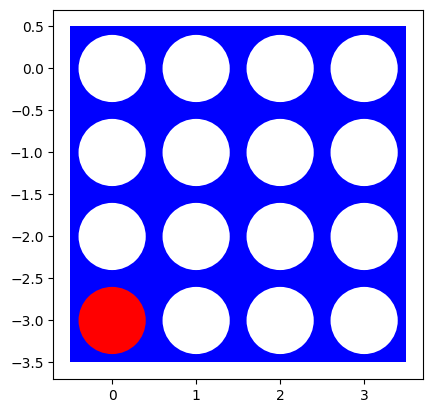

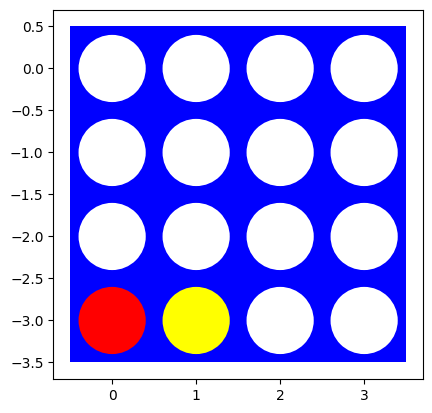


[ 0.08310362 -0.2410631  -0.16670847 -0.22349632]


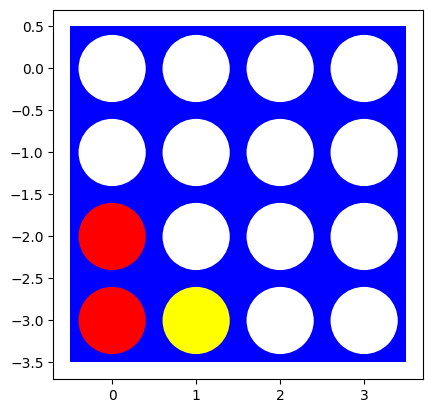

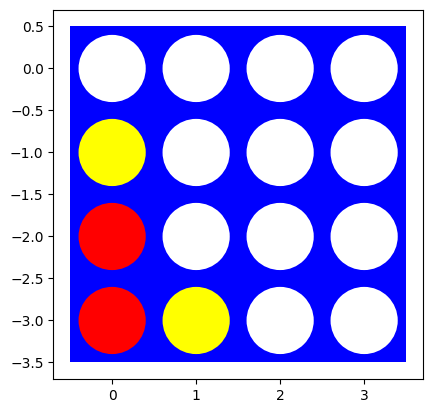


[ 0.08310362 -0.2410631  -0.16670847 -0.22349632]


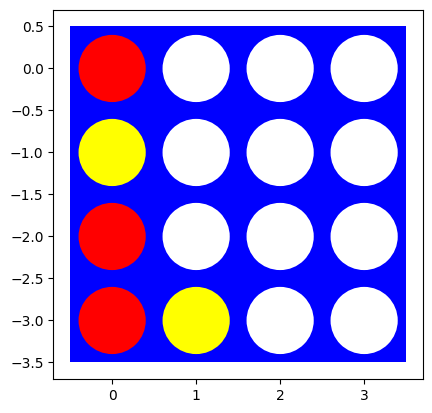

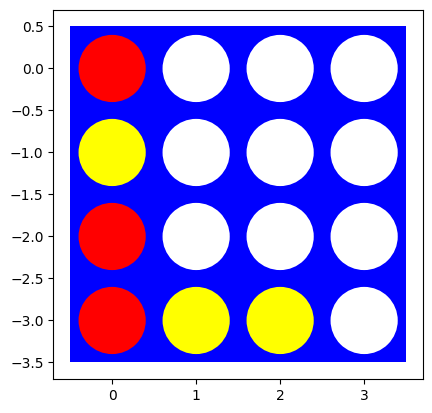


[0.5181532  0.2398486  0.31152806 0.25726995]


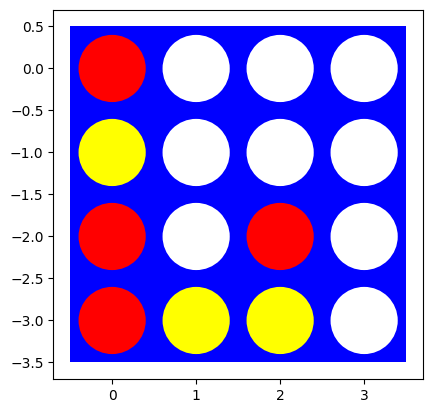

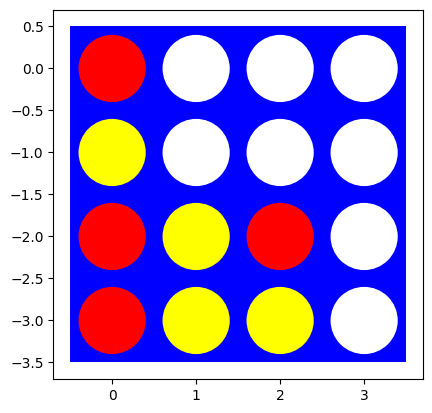


[0.5242144  0.2476759  0.31902274 0.26502421]


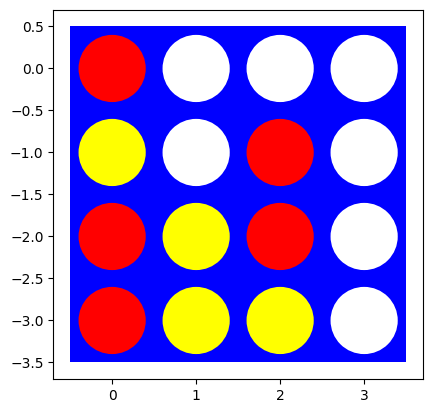

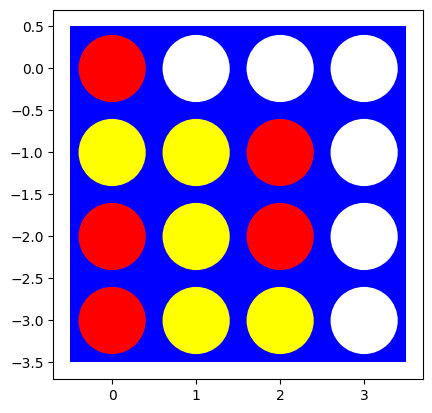


[0.4852328  0.19795924 0.27126703 0.21573342]


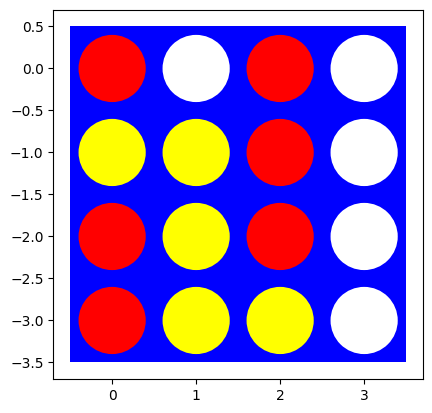

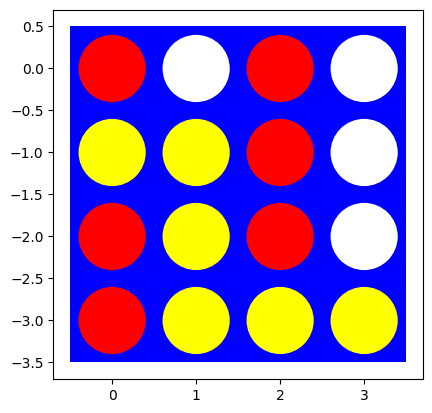


[0.8830712  0.7857973  0.8137301  0.79279745]


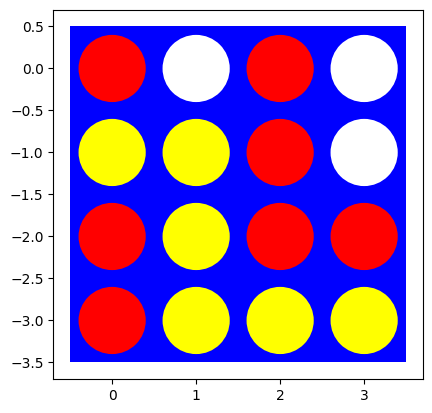

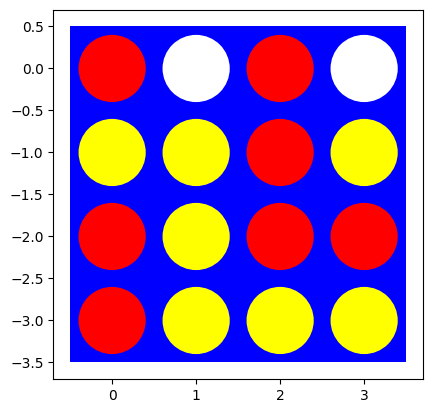


[0.8717328  0.7661975  0.7963948  0.77375704]


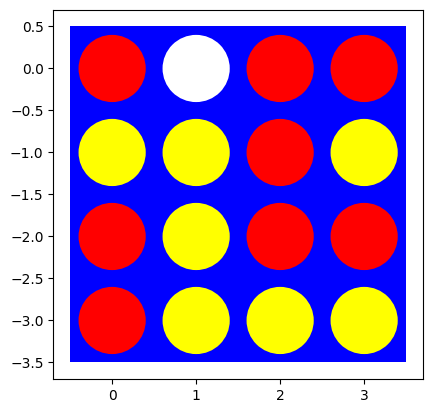

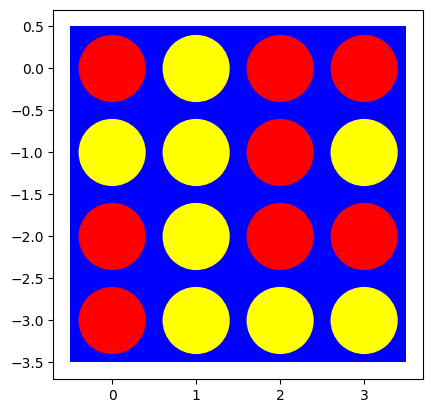

In [8]:
q1.reset()
q2.reset()
q1.epsilon = 0.0
# q2.epsilon = 0.5
b2.reset()
b2.play_agents(verbose=2)

In [9]:
tmp = tf.keras.models.load_model('q_network_q_1_cooling_deep')


In [10]:
tmp([np.zeros(shape=(1,4,4,1)),np.array([1]).reshape(1,1)])

ValueError: Exception encountered when calling layer 'model' (type Functional).

Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 52, but received input with shape (1, 49)

Call arguments received by layer 'model' (type Functional):
  • inputs=['tf.Tensor(shape=(1, 4, 4, 1), dtype=float64)', 'tf.Tensor(shape=(1, 1), dtype=int64)']
  • training=None
  • mask=None